<a href="https://colab.research.google.com/github/aruntakhur/PyTorch_NLP_Vision_New/blob/main/pyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, misc

In [2]:
conv = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3)
conv

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.state_dict()['weight'][0][0]=torch.tensor([[1.0,0,-1.0],[2.0,0,-2.0],[1.0,0.0,-1.0]])
conv.state_dict()['bias'][0]=0.0
conv.state_dict()

OrderedDict([('weight', tensor([[[[ 1.,  0., -1.],
                        [ 2.,  0., -2.],
                        [ 1.,  0., -1.]]]])), ('bias', tensor([0.]))])

In [4]:
#Set the third column to 1
image=torch.zeros(1,1,5,5)
image[0,0,:,2]=1
image

tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]]]])

In [5]:
conv(image)

tensor([[[[-4.,  0.,  4.],
          [-4.,  0.,  4.],
          [-4.,  0.,  4.]]]], grad_fn=<ThnnConv2DBackward0>)

In [6]:
conv5 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=2,stride=3,padding=1)

In [7]:
conv5(image)

tensor([[[[-0.1178, -0.3425],
          [-0.1178, -0.5561]]]], grad_fn=<ThnnConv2DBackward0>)

In [8]:
image = torch.zeros(1,1,5,5)
image[0,0,:,2] = 1
z = conv(image)
z = torch.relu(z)
print(z)
max = torch.nn.MaxPool2d(2,stride = 1)
max(z)
print(max(z))

tensor([[[[0., 0., 4.],
          [0., 0., 4.],
          [0., 0., 4.]]]], grad_fn=<ReluBackward0>)
tensor([[[[0., 4.],
          [0., 4.]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)


MNIST CNN

In [9]:
#helper function
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [10]:
#helper function
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self,N_images=100,offset=0,p=0.9, train=False):
        """
        p:portability that pixel is wight  
        N_images:number of images 
        offset:set a random vertical and horizontal offset images by a sample should be less than 3 
        """
        if train==True:
            np.random.seed(1)  
        
        #make images multiple of 3 
        N_images=2*(N_images//2)
        images=np.zeros((N_images,1,11,11))
        start1=3
        start2=1
        self.y=torch.zeros(N_images).type(torch.long)

        for n in range(N_images):
            if offset>0:
        
                low=int(np.random.randint(low=start1, high=start1+offset, size=1))
                high=int(np.random.randint(low=start2, high=start2+offset, size=1))
            else:
                low=4
                high=1
        
            if n<=N_images//2:
                self.y[n]=0
                images[n,0,high:high+9,low:low+3]= np.random.binomial(1, p, (9,3))
            elif  n>N_images//2:
                self.y[n]=1
                images[n,0,low:low+3,high:high+9] = np.random.binomial(1, p, (3,9))
           
        
        
        self.x=torch.from_numpy(images).type(torch.FloatTensor)
        self.len=self.x.shape[0]
        del(images)
        np.random.seed(0)
    def __getitem__(self,index):      
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

In [11]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
torch.manual_seed(4)

In [13]:
def plot_channels(W):
  #number of output channels 
  n_out = W.shape[0]
  #number of input channels
  n_in = W.shape[1]
  w_min=W.min().item()
  w_max=W.max().item()
  fig, axes  = plt.subplots(n_out, n_in)
  fig.subplots_adjust(hspace = 0.1)
  out_index=0
  in_index=0
  #plot outputs as rows inputs as columns 
  for ax in axes.flat:
    
        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0
              
        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

  plt.show()

In [14]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [15]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [16]:
def show_data(data_sample):
    print("before resize the shape of the data sample is : ", data_sample[0].size())
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [17]:
IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [18]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

In [20]:
# The label for the fourth data element

train_dataset[3][1]

1

before resize the shape of the data sample is :  torch.Size([1, 16, 16])


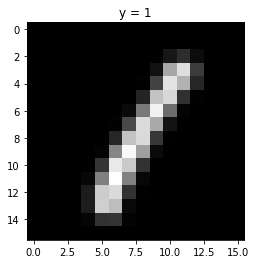

In [21]:
# The image for the fourth data element
show_data(train_dataset[3])

In [22]:
class CNN(nn.Module):
  #constructor
  def __init__(self, out_1 = 16, out_2 = 32):
    super(CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, padding = 2)
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

    self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
    self.fc1 = nn.Linear(out_2*4*4,10)
  
  def forward(self, x):
    x = self.cnn1(x)
    x = torch.relu(x)
    x = self.maxpool1(x)

    x = self.cnn2(x)
    x = torch.relu(x)
    x = self.maxpool2(x)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x

In [23]:
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

In [24]:
model = CNN(out_1 = 16, out_2 = 32)

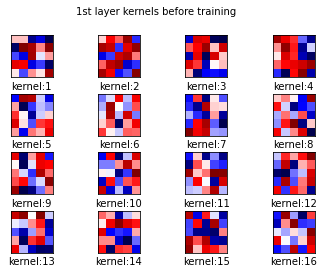

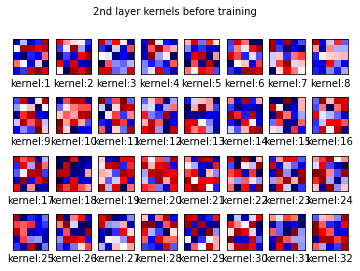

In [25]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [26]:
W = model.state_dict()['cnn1.weight']
W = W.data[:, 0, :, :]
W.shape

torch.Size([16, 5, 5])

In [33]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, shuffle=True, batch_size = 1000 , num_workers=2, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, shuffle = True, batch_size=5000, num_workers=2, pin_memory=True)

In [34]:
n_epochs = 10
cost_list = []
accuracy_list = []
def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / len(validation_dataset)
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

In [ ]:
accuracy_list